<a href="https://colab.research.google.com/github/JulienChoukroun/Automatic-detection-of-sign-language-gestures/blob/main/Automatic_Signal_Detector_Tasks_9_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![PNS](http://caillau.perso.math.cnrs.fr/logo-pns.png)
# **<center>Automatic Signal Detector Project</center>**
<center>CHOUKROUN Julien</center>


---

# README

Here is the link to all my recessaries repository for this projet containing:
- Dataset224.zip
- In Dataset/
  - All the images in A_224, B_224 and C_224
  - In VGG/
    - dataset_vgg.txt and dataset_vgg_suffled.txt
    - VggCnn5/ with the model.json and model_weights.h5
    - New images to test my models with Test_A, Test_B, Test_C, TestDroite and TestGauche

https://drive.google.com/drive/folders/1dd6mjXJVhMVy7rdOoddvBopVBKCOe0eI?usp=sharing

\
To load the OpenCV code there are 2 possibilities:
- If you have downloaded the OpenCV code in your Google Drive, then execute the "drive.mount" command to import your Google Drive.
- Else, clone the repository with the "git clone" command.

1st possibility: import Google Drive to have acces to the OpenCV code and to the dataset (since task 6).

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


2nd possibility: Clone this repository.

In [ ]:
# If not clone, clone it
%cd /content
!git clone https://github.com/opencv/opencv/
%cd opencv/samples/python/

## Ninth Task (Transfer Learning)

Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

Transfer learning is an optimization that allows rapid progress or improved performance when modeling the second task.

Here, we will use the pre-trained model VGG which is a convolutional neural network model. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import glob

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import GlobalAvgPool2D
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.utils import plot_model

In [ ]:
img_height, img_width = 224, 224
batch_size = 32

We unzip our dataset.

In [ ]:
!cp /content/drive/MyDrive/Projet_Computer_Vision/Dataset224.zip .

In [ ]:
!unzip Dataset224.zip -d dataset224

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: dataset224/Dataset224/A/A_287_224_flipped.jpg  
  inflating: dataset224/__MACOSX/Dataset224/A/._A_287_224_flipped.jpg  
  inflating: dataset224/Dataset224/A/A_75_224.jpg  
  inflating: dataset224/__MACOSX/Dataset224/A/._A_75_224.jpg  
  inflating: dataset224/Dataset224/A/A_167_224_flipped.jpg  
  inflating: dataset224/__MACOSX/Dataset224/A/._A_167_224_flipped.jpg  
  inflating: dataset224/Dataset224/A/A_353_224_flipped.jpg  
  inflating: dataset224/__MACOSX/Dataset224/A/._A_353_224_flipped.jpg  
  inflating: dataset224/Dataset224/A/A_197_224.jpg  
  inflating: dataset224/__MACOSX/Dataset224/A/._A_197_224.jpg  
  inflating: dataset224/Dataset224/A/A_187_224.jpg  
  inflating: dataset224/__MACOSX/Dataset224/A/._A_187_224.jpg  
  inflating: dataset224/Dataset224/A/A_389_224.jpg  
  inflating: dataset224/__MACOSX/Dataset224/A/._A_389_224.jpg  
  inflating: dataset224/Dataset224/A/A_221_224_flipped.jp

**Preparing the data for our model**

We decide how much of the dataset we will use for training and validation.

In [ ]:
# Generates a tf.data.Dataset from image files in a directory.

# seed: random seed for shuffling and transformations.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  './dataset224/Dataset224',
  validation_split=0.2,
  subset="training",
  color_mode='rgb',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 3 classes.
Using 2400 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  './dataset224/Dataset224',
  validation_split=0.2,
  subset="validation",
  color_mode='rgb',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 3 classes.
Using 600 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['A', 'B', 'C']


**Configure the dataset for performance**

Use buffered prefetching to load images from disk without having I/O become blocking.

Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. 
Doing so reduces the step time to the maximum of the training and the time it takes to extract the data.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

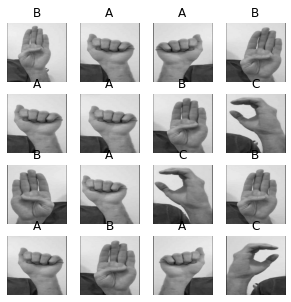

In [ ]:
# Show some images from the train dataset with the labels corresponding.
# To verify that the dataset looks correct, let's plot the first 16 images from the training set and display the class name above each image.
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8").squeeze(), cmap=plt.cm.binary)
    plt.title(class_names[labels[i]])
    plt.axis("off")
  break

In [ ]:
# Load VGG model and weights
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3)) # include_top=False is to not keep the top layer

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
# Architecture of the VGG19 model
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

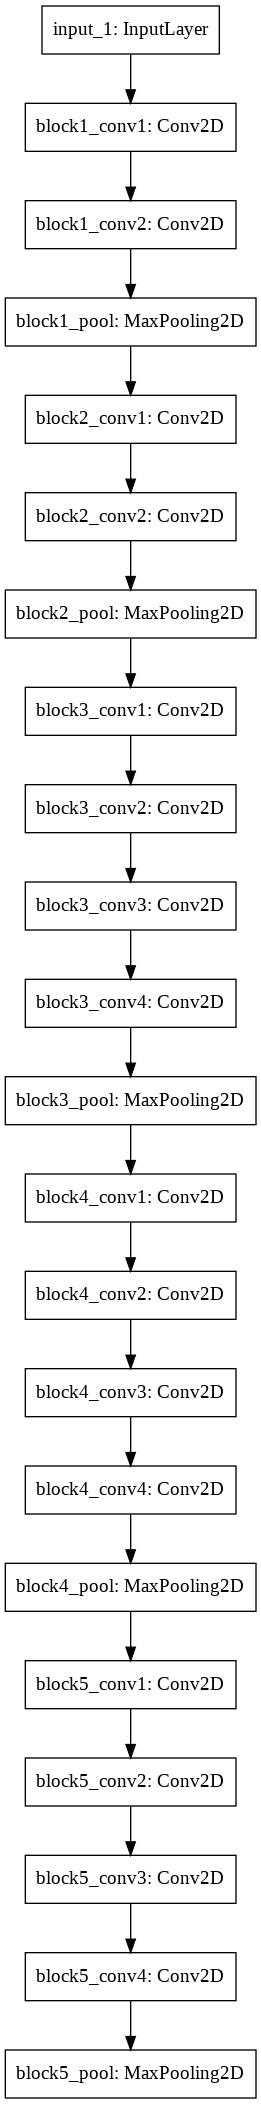

In [ ]:
# Plot the graph of the model
plot_model(vgg_model, to_file='VGG_graph.png')

**Freeze the layer**

It is important to freeze the convolutional base before we compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. VGG16 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [ ]:
for layer in vgg_model.layers:
  layer.trainable = False

We add to the VGG model our finals layers from our CNN from the task 7.

In [ ]:
x = GlobalAvgPool2D()(vgg_model.output)
x = Dense(64, activation='relu')(x)
output = Dense(3)(x)

In [ ]:
model = Model(inputs=vgg_model.input, outputs=output)

In [ ]:
# Architecture of our final model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

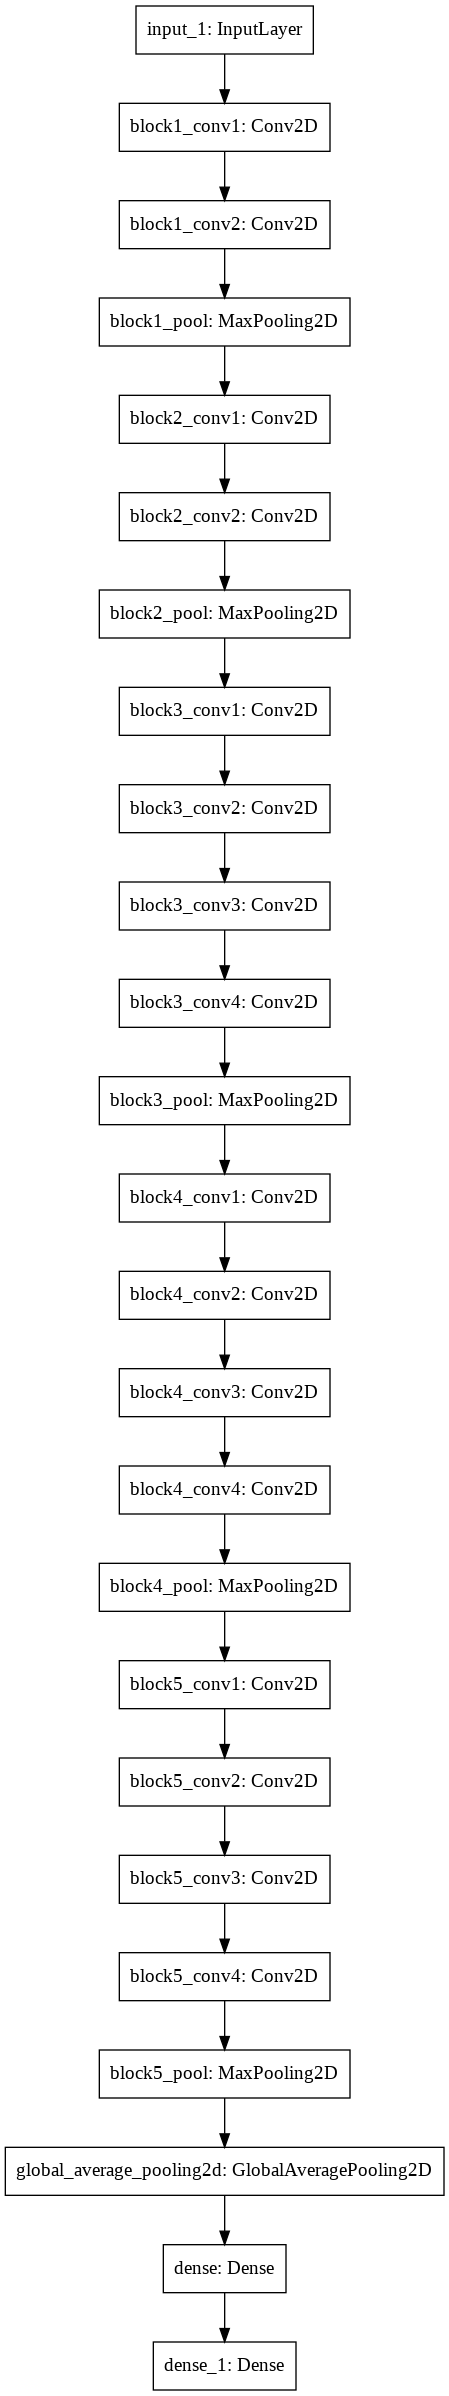

In [ ]:
# Plot the graph of the model
plot_model(model, to_file='VGG_CNN_graph.png')

In [ ]:
# Check the trainable status of the individual layers
for layer in model.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f7b63cdaf50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7b63bce850> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7b63b7f5d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f7b63b4e7d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7b63b576d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7b63b62e50> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f7b63b4e610> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7b6015ee90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7b601655d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7b601652d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7b6015e250> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 

**Model compilation**

Once we have defined our model, it needs to be compiled.
This creates the efficient structures used by the underlying backend in order to efficiently execute our model during training.
We compile our model using the compile() function and it accepts three important attributes:
- Model optimizer.
- Loss function.
- Metrics.

The optimizer is the search technique used to update weights in our model.
Some popular gradient descent optimizers: 
- SGD (stochastic gradient descent with support of momentum)
- RMSprop (adaptive learning rate optimization method proposed by Geoffrey Hinton)
- Adam (Adaptive Moment Estimation that also uses adaptive learning rates)

The loss function, also called the objective function is the evaluation of the model used by the optimizer to navigate the weight space. This function is used to compute the error as the difference between the actual output and the predicted output.
Some common examples include:
- mse: for mean squared error
- binary_crossentropy: for binary logarithmic loss (logloss)
- categorical_crossentropy: for multi-class logarithmic loss (logloss)
- tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True): computes the crossentropy loss between the labels and predictions. Using from_logits=True may be more numerically stable.

Metrics are evaluated by the model during training.
Only one metric is supported at the moment and that is accuracy.

In [ ]:
# Model compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Calling tf.config.run_functions_eagerly(True) will make all invocations of tf.function run eagerly instead of running as a traced graph function.

This can be useful for debugging.

In [ ]:
tf.config.run_functions_eagerly(True)

**Model training**

The model is trained on NumPy arrays using the fit() function.

Epochs is the number of times that the model is exposed to the training dataset.

Batch_size is the number of samples that will be propagated through the network.

The fit function also allows for some basic evaluation of the model during training. We can provide a validation_data tuple of (x, y) of data to evaluate.

Fitting the model returns a history object with details and metrics calculated for the model each epoch. This can be used for graphing model performance.

In [ ]:
# Model training
history = model.fit(train_ds, 
                    epochs=5, 
                    validation_data=val_ds)

Epoch 1/5
75/75 [==============================] - 146s 1s/step - loss: 0.4755 - accuracy: 0.9093 - val_loss: 1.5565e-04 - val_accuracy: 1.0000
Epoch 2/5
75/75 [==============================] - 106s 1s/step - loss: 7.8924e-05 - accuracy: 1.0000 - val_loss: 6.9055e-05 - val_accuracy: 1.0000
Epoch 3/5
75/75 [==============================] - 106s 1s/step - loss: 3.9226e-05 - accuracy: 1.0000 - val_loss: 4.3139e-05 - val_accuracy: 1.0000
Epoch 4/5
75/75 [==============================] - 106s 1s/step - loss: 2.5665e-05 - accuracy: 1.0000 - val_loss: 3.0624e-05 - val_accuracy: 1.0000
Epoch 5/5
75/75 [==============================] - 106s 1s/step - loss: 1.8743e-05 - accuracy: 1.0000 - val_loss: 2.3434e-05 - val_accuracy: 1.0000


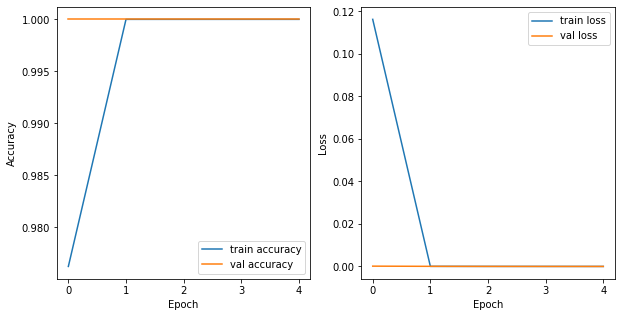

In [ ]:
# Plot the accuracy and the loss according to the epochs

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

**Model prediction**

Once we have trained our model, we can use it to make predictions on test data or new data.

We will use the model.evaluate() function to calculate the loss values for and the accuracy input data.

In [ ]:
# Model prediction
score = model.evaluate(val_ds, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 2.3433565729646944e-05
Validation accuracy: 1.0


In [ ]:
# Save the model and the weights. 
# Because every time we train our model, the initialization is random then we will have different results. 

model_json = model.to_json()
with open("/content/drive/MyDrive/Projet_Computer_Vision/Dataset/VGG/VggCnn5/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/drive/MyDrive/Projet_Computer_Vision/Dataset/VGG/VggCnn5/model_weights.h5")
print("Saved model to disk")

Saved model to disk


**Conclusion**

To set the best number of epochs, I have tested with different number of epochs. And I have found that the best is to choose 5 epochs for my training.

Here some examples of training with 5 and 10 epochs:

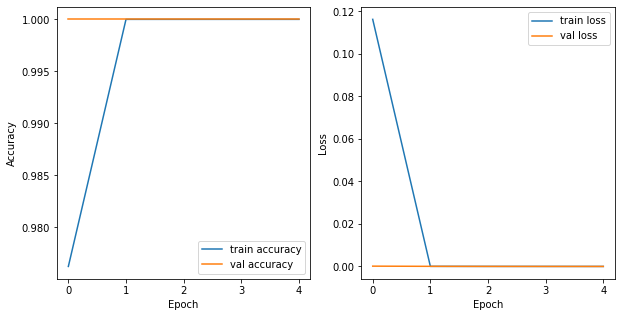

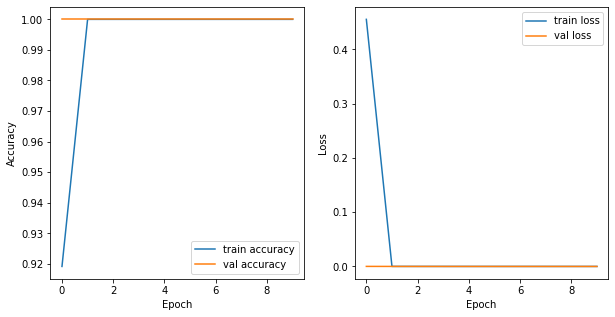

So we can see that with 5 epochs, the training is efficient, so we can stop at 5 epochs.

**Test phase**

In [ ]:
from keras.models import model_from_json

# We load the model
# Load json and create model
json_file = open('/content/drive/MyDrive/Projet_Computer_Vision/Dataset/VGG/VggCnn5/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# Load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Projet_Computer_Vision/Dataset/VGG/VggCnn5/model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


To verify that the model loaded correctly, run the next 2 blocks.
We must have the same loss and accuracy as in the task 7.

In [ ]:
# Model compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Model prediction
score = model.evaluate(val_ds, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 2.3433565729646944e-05
Validation accuracy: 1.0


**Generate new images to predict the letter (from the code from the task 6)**

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import io
from google.colab.patches import cv2_imshow
import cv2 # OpenCV library

In [ ]:
# Create a real time video stream
def VideoCapture():
  js = Javascript('''
    async function create(){
      div = document.createElement('div');
      document.body.appendChild(div);

      video = document.createElement('video');
      video.setAttribute('playsinline', '');

      div.appendChild(video);
      stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: "environment"}});
      video.srcObject = stream;

      await video.play();

      canvas =  document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      div_out = document.createElement('div');
      document.body.appendChild(div_out);
      img = document.createElement('img');
      div_out.appendChild(img);
    }

    async function capture(){
        return await new Promise(function(resolve, reject){
            pendingResolve = resolve;
            canvas.getContext('2d').drawImage(video, 0, 0);
            result = canvas.toDataURL('image/jpeg', 0.20);

            pendingResolve(result);
        })
    }

    function showimg(imgb64){
        img.src = "data:image/jpg;base64," + imgb64;
    }

  ''')
  display(js)

In [ ]:
# Format transformation
def b64_to_bytes(byte):
  jpeg = b64decode(byte.split(',')[1])
  im = Image.open(io.BytesIO(jpeg))
  return np.array(im)

def bytes_to_b64(image):
  image = Image.fromarray(image)
  buffer = io.BytesIO()
  image.save(buffer, 'jpeg')
  buffer.seek(0)
  x = b64encode(buffer.read()).decode('utf-8')
  return x

In [ ]:
# This function scales a rotated rectangle by a factor of scale_x (width) and scale_y (height)
def scale_contour(pts, scale_x, scale_y):
    M = cv2.moments(pts)

    if M['m00'] == 0:
      return pts

    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    cnt_norm = pts - [cx, cy]
    cnt_scaled = cnt_norm * np.array([scale_x, scale_y])
    cnt_scaled = cnt_scaled + [cx, cy]
    cnt_scaled = cnt_scaled.astype(np.int32)

    return cnt_scaled

# This function crop the hand
# Here we don't retrieve directly the rotated box because it might change the letter. 
# So we compute first a new non rotated bbox, and use it to crop the hand.
def crop_hand(pts, im_width, im_height):
    x_tl, y_tl = max(0, min(pts[:, 0])), max(0, min(pts[:, 1])) # We have the different corners of the rotated bounding box
    x_br, y_br = min(im_width, max(pts[:, 0])), max(im_height, max(pts[:, 1])) # We compute those of the non rotated one arround
    return (x_tl, y_tl), (x_br, y_br)

If you have loaded your Google Drive, then execute this box but not the next box.

In [ ]:
# Load the cascade classifier
# ! Be careful for the path. You have to change the path with the path of your Google Drive !
faces_cascades = cv2.CascadeClassifier("/content/drive/MyDrive/Projet_Computer_Vision/opencv-master/data/haarcascades/haarcascade_frontalface_alt.xml")

If you have cloned the repository, then execute this box.

In [ ]:
# Load the cascade classifier
faces_cascades = cv2.CascadeClassifier("/content/opencv/data/haarcascades/haarcascade_frontalface_alt.xml")

In [ ]:
# Detect faces using cascades
# Detect the face in the image
# Detects objects of different sizes in the input image
# The detected objects are returned as a list of rectangles

# In detectMultiScale, the second parameter is the scaleFactor: how much the image size is reduced at each image scale
# And the last parameter is the minNeighbors: how many neighbors each candidate rectangle should have to retain it
def detect_faces(img, cascades):
  # Convert the image into gray scale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Use cascades to detect faces
  faces = cascades.detectMultiScale(gray, 1.3, 4)
  return faces

In [ ]:
# Capture a frame used for histogramm backprojection
VideoCapture()
eval_js('create()')

while True:
  response = input("Type anything when ready!:")
  byte = eval_js('capture()') # Take a capture
  im = b64_to_bytes(byte) # Transform the capture from base64 to an array
  im_copy = im.copy()
  faces = detect_faces(im, faces_cascades) # Detect faces

  if len(faces) == 1: # If the algorithm detects a face
    face = faces[0]
    # Draw a green rectangle around the detected face in the image
    cv2.rectangle(im_copy,(face[0],face[1]),(face[0] + face[2], face[1] + face[3]),(0,255,0),2)
  else:
    continue

  eval_js('showimg("{}")'.format(bytes_to_b64(im_copy))) # We convert our image with bounding boxes to base64 and plot it using JS 
  response = input("Use this bounding box? [y or n]:")
  if response == 'y': # Take a screen shot
    frame = im[face[1]:face[1]+face[3], face[0]:face[0]+face[2]]
    eval_js('showimg("{}")'.format(bytes_to_b64(frame)))
    tracking_window_face = face # Initial tracking window for the face
    break

<IPython.core.display.Javascript object>

Type anything when ready!:ok
Use this bounding box? [y or n]:y


In [ ]:
# Compute the histogram

# Transform the frame into HSV
frameHSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
# Create an inRange mask for pixels. Limit the saturation in [64., 255.] and brightness in [32., 200.]
mask = cv2.inRange(frameHSV, np.array((8., 64., 32.)), np.array((180., 255., 200.)))
# Compute the histogram of the frame (use only the HUE channel). See `https://bit.ly/3pdVUEd`
# Take into account only pixels which are not too bright and not too dark (use the previous mask)
# Use 16 bins and specify the range of the hue ([0, 180])
frameHist = cv2.calcHist([frameHSV], [0], mask, [16], [0, 180])
# Normalize the histogram between 0 (lowest intensity) and 255 (highest intensity) (use MinMax normalization `cv.NORM_MINMAX`) using the method `https://bit.ly/3jMGhCj`
frameHist = cv2.normalize(frameHist, frameHist, 0, 255, cv2.NORM_MINMAX)
# Reashape the histogram into a 1-D array (use `.reshape(-1)`)
frameHist = frameHist.reshape(-1)
# Show the histogram
#show_hist(frameHist)

In [ ]:
sv = tracking_window_face

In [ ]:
PATH = '/content/drive/MyDrive/Projet_Computer_Vision/Dataset/VGG/TestC/'

In [ ]:
tracking_window_face = sv

VideoCapture()
eval_js('create()')
# These mean: Stop the mean-shift algorithm iff we effectuated 10 iterations or the computed mean does not change by more than 1pt ~ 1.3px in both directions
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

# Take a capture from the video
byte = eval_js('capture()')
# Retrieves the width and height of the image
im_width, im_height = im.shape[1],im.shape[0] # To be used in the boundary constraints
# Transform the capture from base64 to an array
im = b64_to_bytes(byte)

tracking_window_hand = (0,0,im_width,im_height) # Define the initial tracking window for the hand. It spans the entire caption

# Initialise a counter, so the first image will be the image 0
cpt = -1

while True:
  byte = eval_js('capture()') # Take a capture
  im = b64_to_bytes(byte) # Transform the capture from base64 to an array

  # Transform the image into HSV
  frameHSV = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # Compute the standard not too bright not too dark mask
  mask = cv2.inRange(frameHSV, np.array((0., 64., 32.)), np.array((180., 200., 200.)))

  # Back project the histogramm on the hsv img. Use only channel 0 (Hue), range of [0,180] and scale of 1
  prob = cv2.calcBackProject([frameHSV], [0], frameHist, [0, 180], scale=1)

  # Apply the mask
  prob = prob & mask
  (x,y,w,h) = tracking_window_face # Area contains the face detection result
  # First look up for the face using cam shift starting from `tracking_window_face`
  # The first parameter is the back projection, the second parameter is the tracking window (this has been first computed in the beginning)
  bbox, tracking_window_face = cv2.CamShift(prob, tracking_window_face, term_crit) # Use new prob to do CamShift

  # Retrieve the rotated bounding rectangle
  pts = cv2.boxPoints(bbox).astype(np.int)

  # Find the centroid of image and better scale the bounding box
  # Scale the rotated bounding box 1.5x times  
  scaled_pts = scale_contour(pts, 1.5, 1.5)

  # Fill the rotated face bounding box with 0 in the prob map
  cv2.fillPoly(prob, [scaled_pts], 0)

  # Draw the bounding box around the face
  #cv2.polylines(prob, [pts], True, (255, 255 , 255), 2) # Draw a rectangle around the face
  #cv2.polylines(prob, [scaled_pts], True, (255, 255 , 0), 2)
  #cv2.polylines(im, [scaled_pts], True, (255, 255 , 0), 2) # Draw a rectangle around the face

  # Now look up for the hand using cam shift starting from `tracking_window_hand`

  bbox, tracking_window_hand = cv2.CamShift(prob, tracking_window_hand, term_crit)

  pts = cv2.boxPoints(bbox).astype(np.int) # Retrieve the rotated bounding rectangle

  # Find the centroid of image and better scale the bounding box
  # Scale the contour around the hand
  pts = scale_contour(pts, 1.9, 1.6)

  # Hand detected
  cropped_hand_bbox = crop_hand(pts, im_width, im_height)

  #cv2.polylines(prob, [pts], True, (255, 255 , 255), 2) # Draw a rectangle around the hand
  #cv2.polylines(im, [pts], True, (255, 255 , 255), 2)
  cv2.rectangle(im, cropped_hand_bbox[0], cropped_hand_bbox[1], (255, 0, 0), 2) # Draw a rectangle around the cropped hand

  # Transform the color image into gray image
  cropped_hand = cv2.cvtColor(im[cropped_hand_bbox[0][1]:cropped_hand_bbox[1][1], cropped_hand_bbox[0][0]:cropped_hand_bbox[1][0]], cv2.COLOR_BGR2GRAY)
  # We create two sizes of images: 32x32 and 224x224 (16x16 is not very good)
  cropped_hand = cv2.resize(cropped_hand, (224,224))
  
  cpt += 1

  # Once we have detected the hand, we store it as an image
  cv2.imwrite(PATH + 'C_' + str(cpt) + '.jpg', cropped_hand)

  ## Draw the bounding box around the hand
  #eval_js('showimg("{}")'.format(bytes_to_b64(prob))) # Show the prob image
  eval_js('showimg("{}")'.format(bytes_to_b64(im))) # Show the image

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

**Prediction**

After saving the image, we reload it and resize it to pass to our model. Then we predict the letter.

Remember that we used the Softmax activation function when creating our model. This activation function doesn’t compute the prediction, but rather a discrete probability distribution over the target classes.
Now, we can finalize our work by actually finding out what our predicted classes are, by taking the argmax values (or “maximum argument”, index of the maximum value), with the function argmax().

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


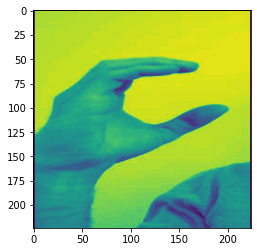

I think the letter is a C and the real one is: C


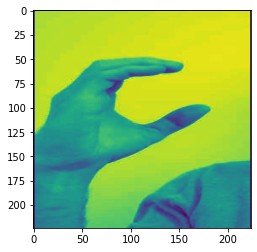

I think the letter is a C and the real one is: C


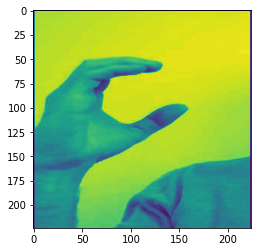

I think the letter is a C and the real one is: C


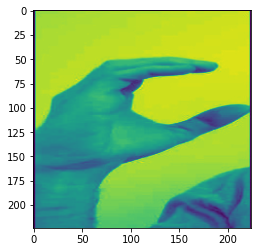

I think the letter is a C and the real one is: C


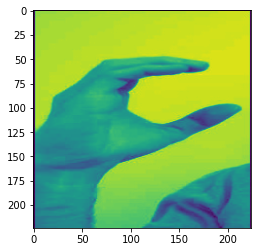

I think the letter is a C and the real one is: C


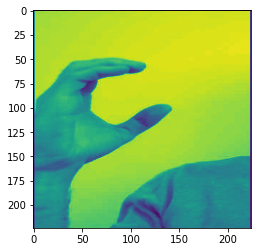

I think the letter is a C and the real one is: C


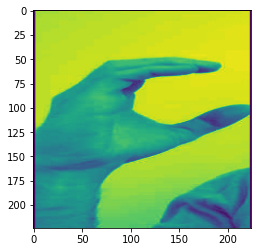

I think the letter is a C and the real one is: C


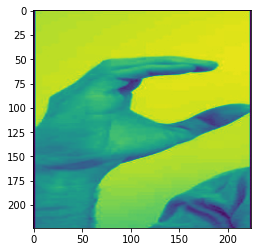

I think the letter is a C and the real one is: C


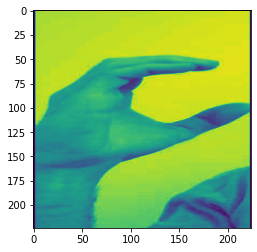

I think the letter is a C and the real one is: C


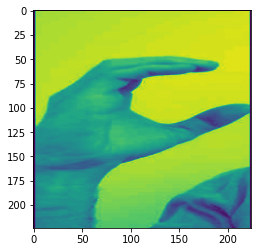

I think the letter is a C and the real one is: C


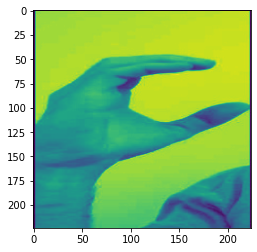

I think the letter is a C and the real one is: C


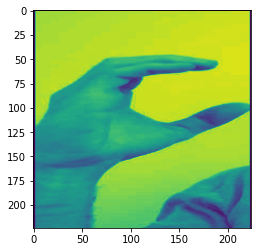

I think the letter is a C and the real one is: C


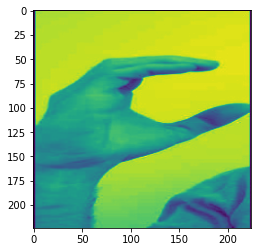

I think the letter is a C and the real one is: C


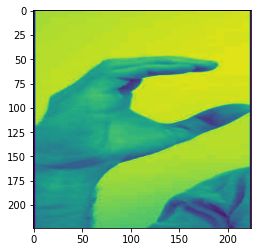

I think the letter is a C and the real one is: C


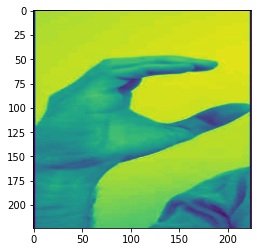

I think the letter is a C and the real one is: C


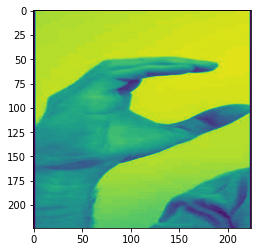

I think the letter is a C and the real one is: C


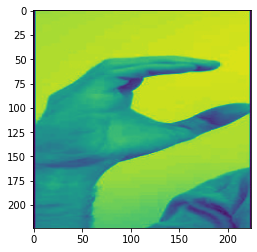

I think the letter is a C and the real one is: C


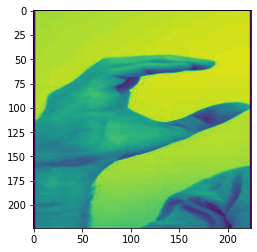

I think the letter is a C and the real one is: C


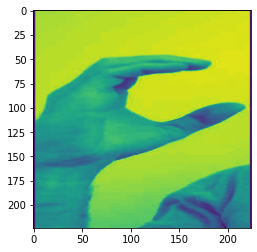

I think the letter is a C and the real one is: C


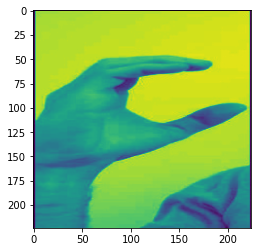

I think the letter is a C and the real one is: C


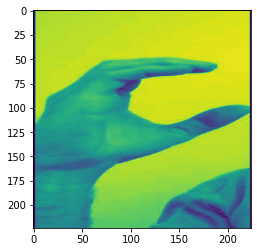

I think the letter is a C and the real one is: C


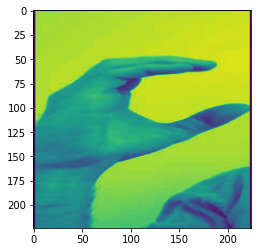

I think the letter is a C and the real one is: C


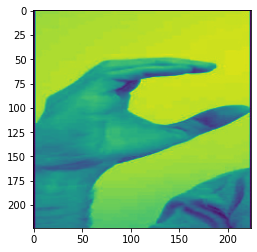

I think the letter is a C and the real one is: C


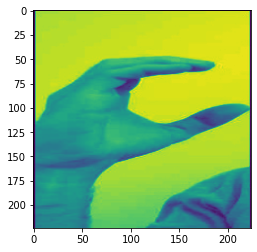

I think the letter is a C and the real one is: C


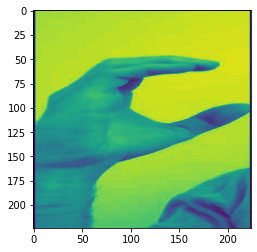

I think the letter is a C and the real one is: C


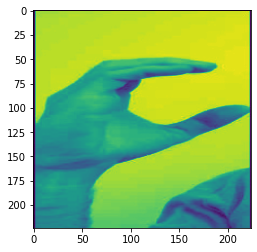

I think the letter is a C and the real one is: C


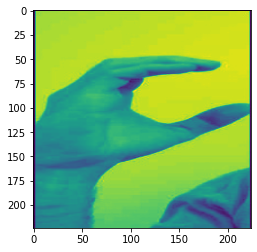

I think the letter is a C and the real one is: C


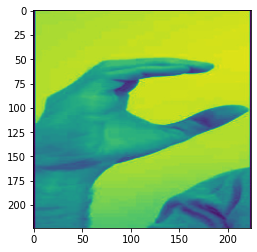

I think the letter is a C and the real one is: C


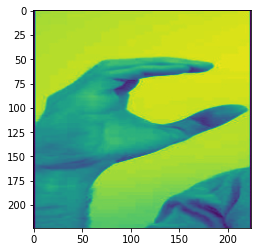

I think the letter is a C and the real one is: C


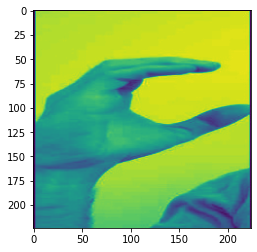

I think the letter is a C and the real one is: C


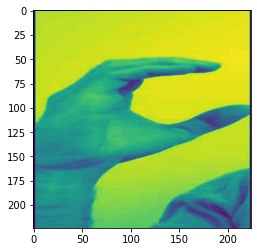

I think the letter is a C and the real one is: C


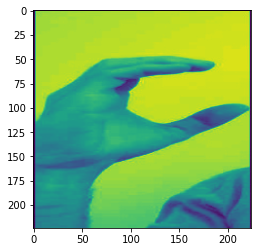

I think the letter is a C and the real one is: C


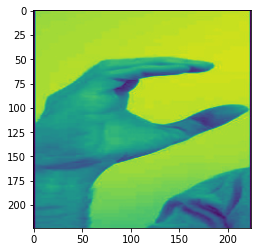

I think the letter is a C and the real one is: C


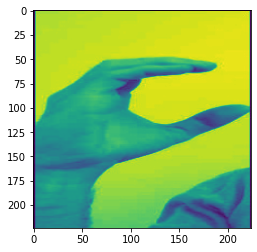

I think the letter is a C and the real one is: C


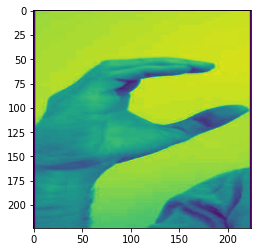

I think the letter is a C and the real one is: C


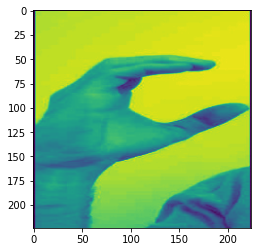

I think the letter is a C and the real one is: C


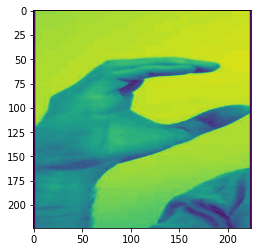

I think the letter is a C and the real one is: C


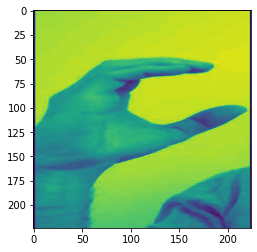

I think the letter is a C and the real one is: C


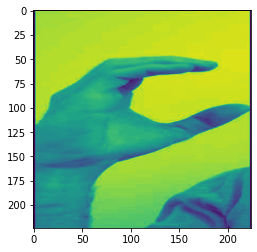

I think the letter is a C and the real one is: C


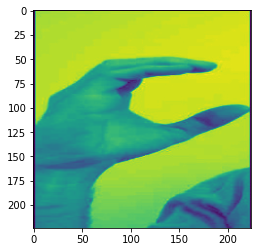

I think the letter is a C and the real one is: C


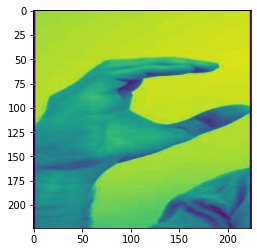

I think the letter is a C and the real one is: C


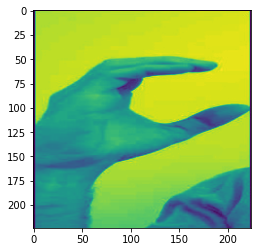

I think the letter is a C and the real one is: C


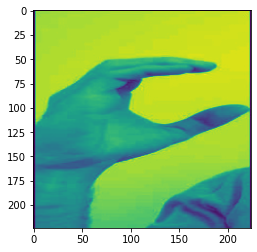

I think the letter is a C and the real one is: C


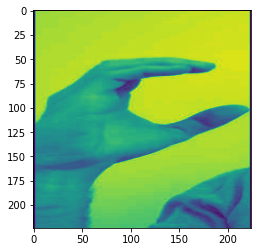

I think the letter is a C and the real one is: C


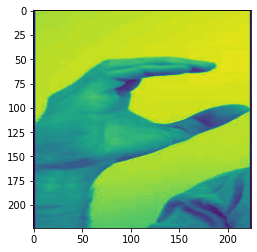

I think the letter is a C and the real one is: C


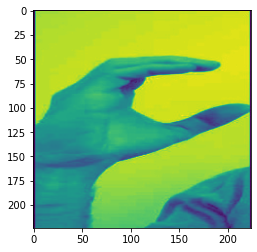

I think the letter is a C and the real one is: C


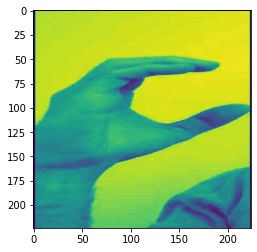

I think the letter is a C and the real one is: C


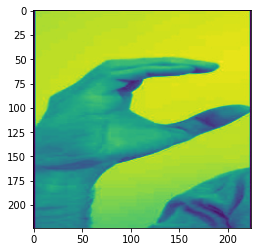

I think the letter is a C and the real one is: C


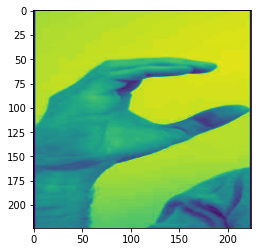

I think the letter is a C and the real one is: C


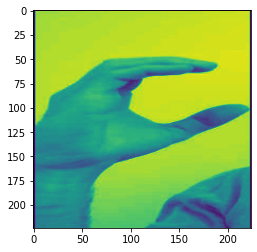

I think the letter is a C and the real one is: C


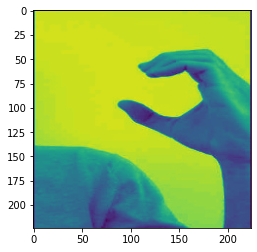

I think the letter is a C and the real one is: C


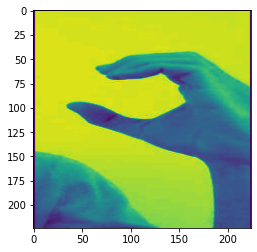

I think the letter is a C and the real one is: C


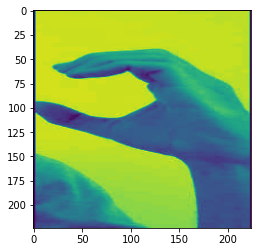

I think the letter is a C and the real one is: C


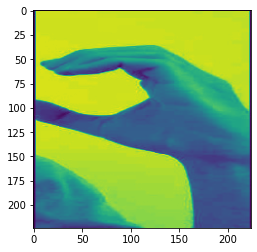

I think the letter is a C and the real one is: C


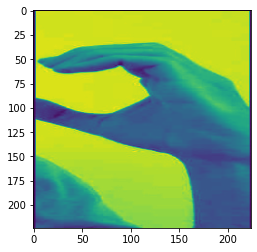

I think the letter is a C and the real one is: C


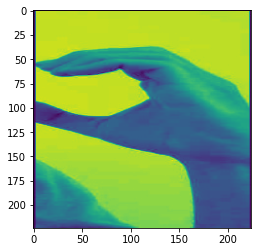

I think the letter is a C and the real one is: C


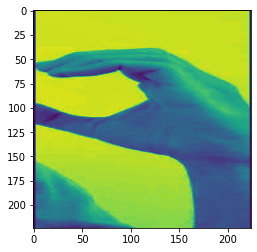

I think the letter is a C and the real one is: C


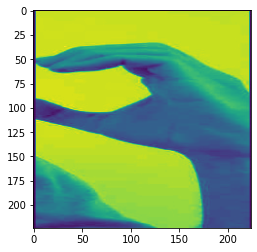

I think the letter is a C and the real one is: C


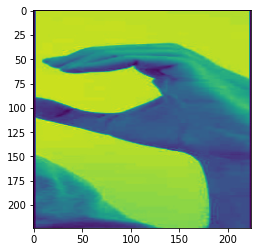

I think the letter is a C and the real one is: C


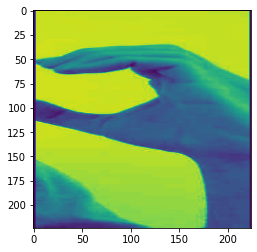

I think the letter is a C and the real one is: C


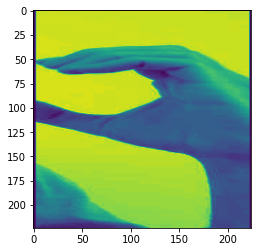

I think the letter is a C and the real one is: C


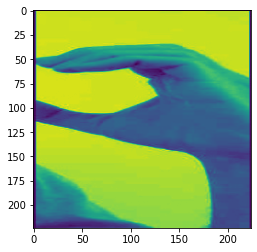

I think the letter is a C and the real one is: C


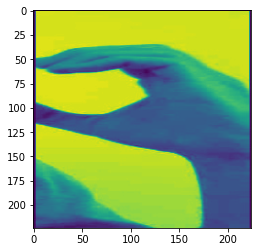

I think the letter is a C and the real one is: C


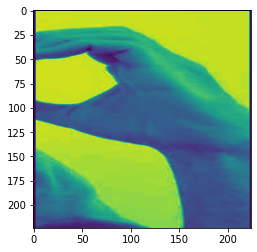

I think the letter is a C and the real one is: C


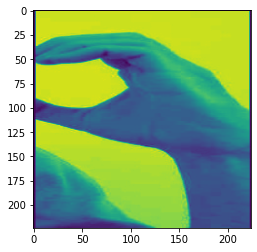

I think the letter is a C and the real one is: C


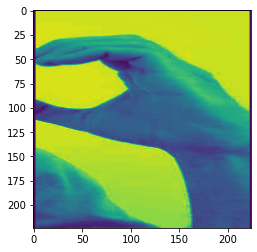

I think the letter is a C and the real one is: C


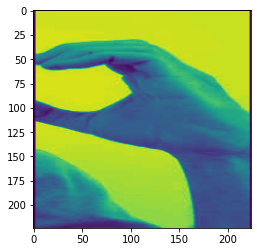

I think the letter is a C and the real one is: C


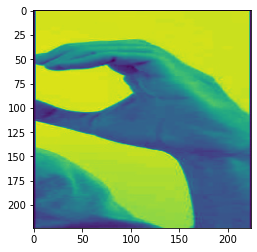

I think the letter is a C and the real one is: C


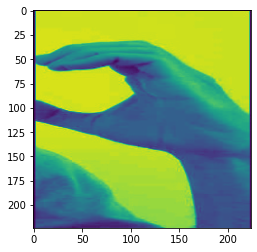

I think the letter is a C and the real one is: C


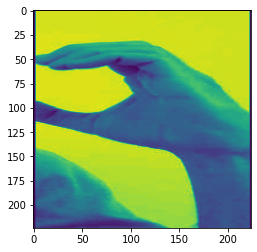

I think the letter is a C and the real one is: C


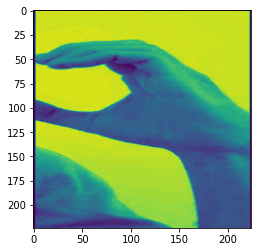

I think the letter is a C and the real one is: C


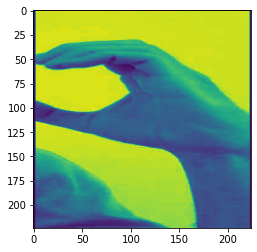

I think the letter is a C and the real one is: C


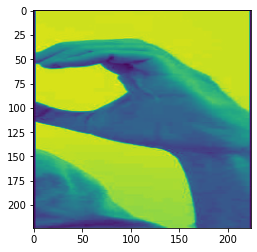

I think the letter is a C and the real one is: C


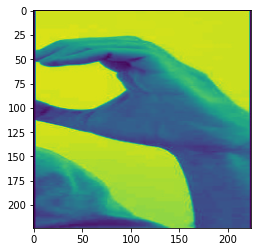

I think the letter is a C and the real one is: C


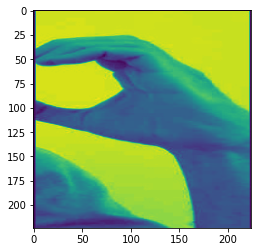

I think the letter is a C and the real one is: C


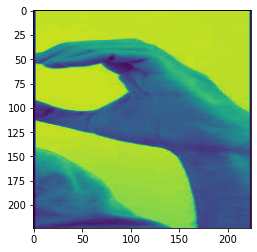

I think the letter is a C and the real one is: C


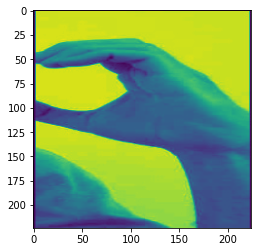

I think the letter is a C and the real one is: C


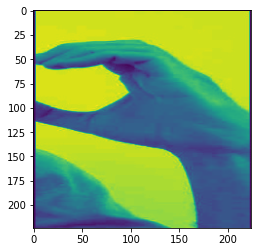

I think the letter is a C and the real one is: C


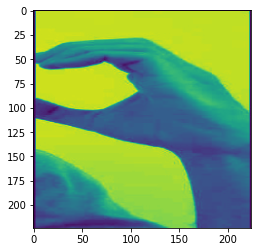

I think the letter is a C and the real one is: C


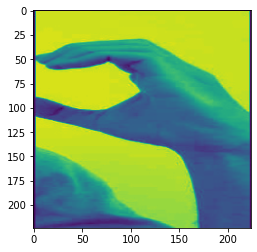

I think the letter is a C and the real one is: C


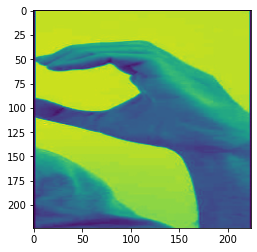

I think the letter is a C and the real one is: C


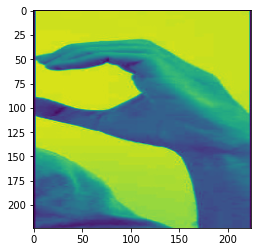

I think the letter is a C and the real one is: C


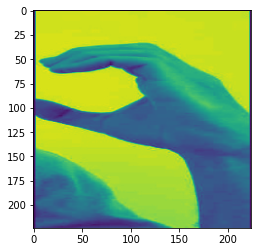

I think the letter is a C and the real one is: C


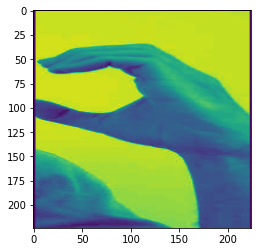

I think the letter is a C and the real one is: C


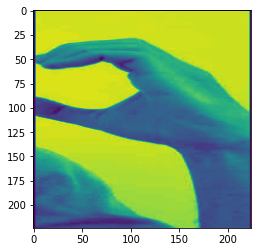

I think the letter is a C and the real one is: C


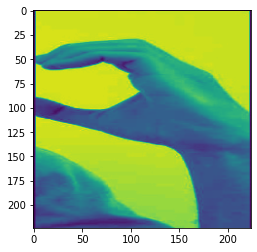

I think the letter is a C and the real one is: C


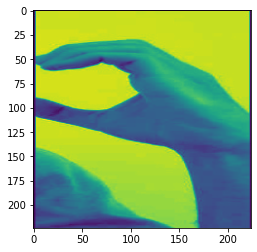

I think the letter is a C and the real one is: C


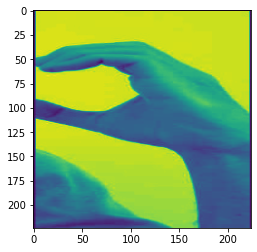

I think the letter is a C and the real one is: C


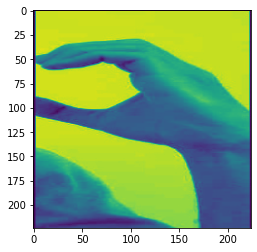

I think the letter is a C and the real one is: C


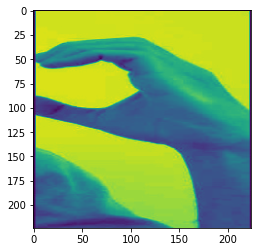

I think the letter is a C and the real one is: C


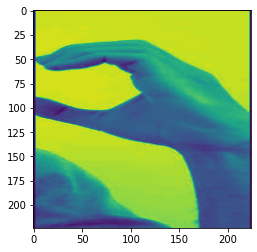

I think the letter is a C and the real one is: C


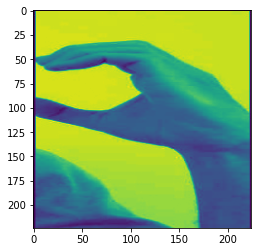

I think the letter is a C and the real one is: C


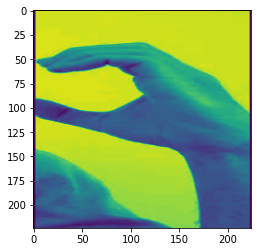

I think the letter is a C and the real one is: C


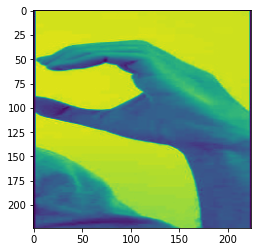

I think the letter is a C and the real one is: C


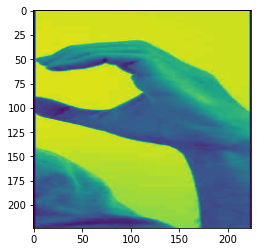

I think the letter is a C and the real one is: C


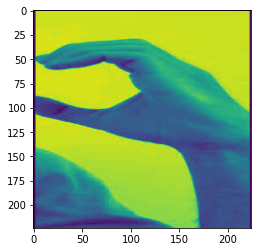

I think the letter is a C and the real one is: C


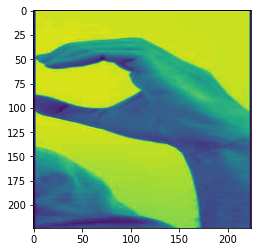

I think the letter is a C and the real one is: C


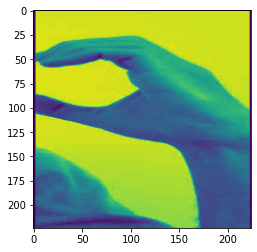

I think the letter is a C and the real one is: C


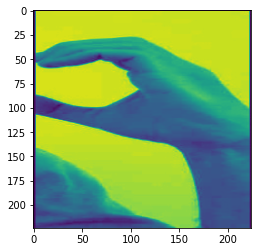

I think the letter is a C and the real one is: C


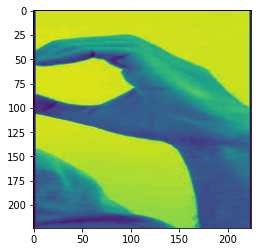

I think the letter is a C and the real one is: C
 
The execution time for 100 images is: 92.53114676475525
The number of errors is: 0
The accuracy is: 1.0


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import os
import time

mypath="/content/drive/MyDrive/Projet_Computer_Vision/Dataset/VGG/Test_C"

# Create an array with all the images in '.jpg'
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

t1 = time.time()
cpt = 0
for x in onlyfiles:
  imPath=mypath + '/' + x # The path to an image
  hand_image=Image.open(imPath).convert('RGB') # Load saved image and convert into 'RGB' color useful for the network input

  hand_image = np.asarray(hand_image)
  hand_image=np.reshape(hand_image,(-1,224,224,3))

  prediction = loaded_model.predict(hand_image) # Where hand_image is the probability image of your hand
  prediction = prediction.argmax() # prediction variable will be 0, 1 or 2 for A, B or C respectively
  predicted_letter = chr(ord('A') + prediction)

  # We show the images
  img=plt.imread(imPath)
  imgplot=plt.imshow(img)
  plt.show()
  
  print("I think the letter is a " + predicted_letter + " and the real one is: " + x[0])

  if (predicted_letter == x[0]):
    cpt += 1

print(" ")
t2 = time.time()
t_final = t2-t1
print("The execution time for", len(onlyfiles),"images is:", t_final)

print("The number of errors is:", len(onlyfiles)-cpt)
print("The accuracy is:", cpt/len(onlyfiles))

**Conclusion**

We observe that the Transfer learning is very accurate (same as the CNN and more accurate than the MLP). But the execution time here is greater than the execution time for the MLP or for the CNN. Indeed, the scores are:
* For the letter A, the execution time for 100 images is **91.89** seconds and the accuracy is **0.98**.
* For the letter B, the execution time for 100 images is **90.94** seconds and the accuracy is **0.95**.
* For the letter C, the execution time for 100 images is **92.53** seconds and the accuracy is **1.0**.

Notice that when we predict with a dataset with all the 3 letters shuffled, the accuracy is roughly 0.98.

**Visualizing Feature maps or Activation maps generated in a CNN**

Feature maps are generated by applying Filters or Feature detectors to the input image or the feature map output of the prior layers. Feature map visualization will provide insight into the internal representations for specific input for each of the Convolutional layers in the model.

Visualizing an inside story of how CNN learns to identify different features present in images provides a deeper insight into how the model works. It will also help to understand why the model might be failing to classify some of the images correctly and hence fine-tuning the model for better accuracy and precision.

(1, 224, 224, 64)
(1, 224, 224, 64)
(1, 112, 112, 64)
(1, 112, 112, 128)
(1, 112, 112, 128)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


(1, 56, 56, 128)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 28, 28, 256)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 7, 7, 512)
(1, 512)
(1, 64)
(1, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


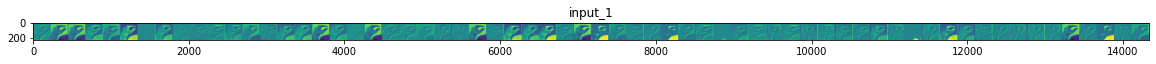

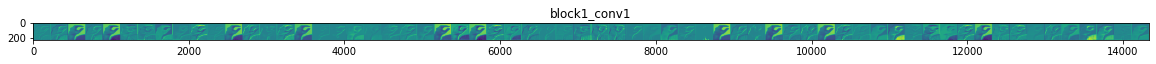

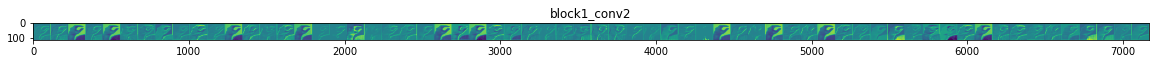

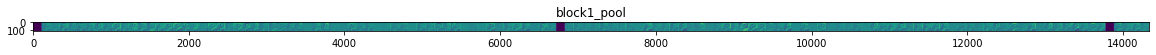

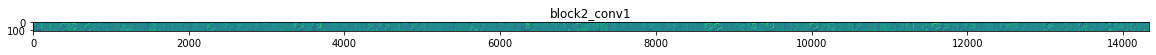

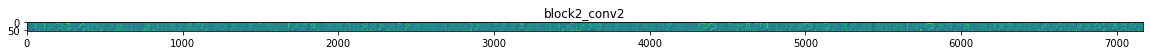

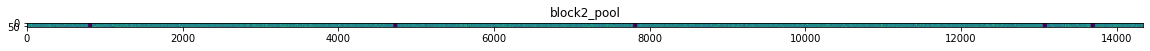

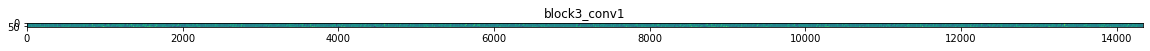

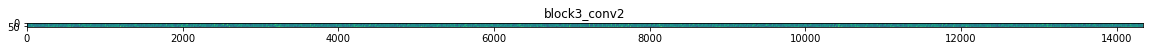

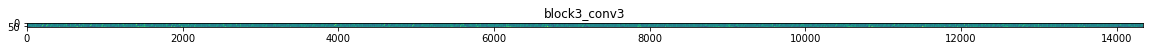

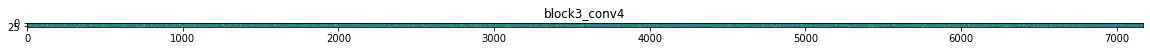

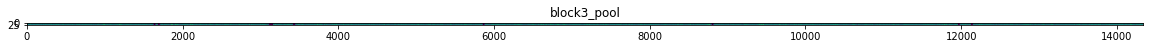

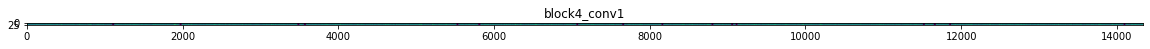

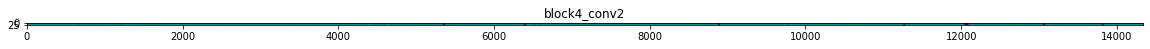

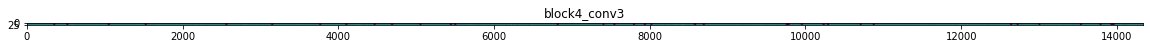

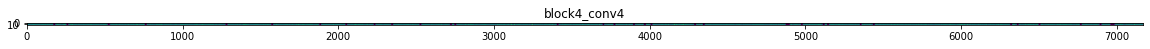

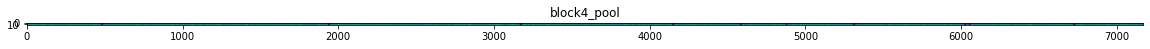

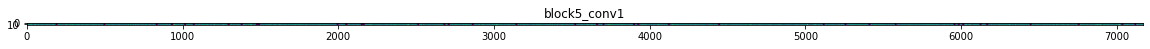

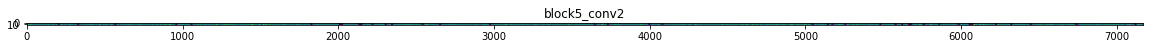

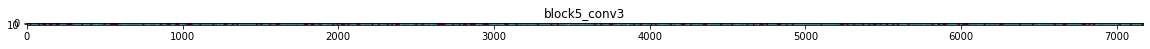

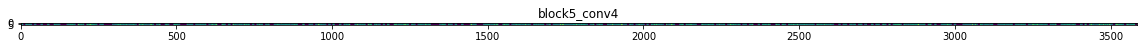

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

img_path='/content/drive/MyDrive/Projet_Computer_Vision/Dataset/C_224/C_0_224.jpg'

# Define a new model, visualization_model that will take an image as the input. 
# The output of the model will be feature maps, which are an intermediate representation for all layers after the first layer. 
# This is based on the model we have used for training.
successive_outputs = [layer.output for layer in loaded_model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = loaded_model.input, outputs = successive_outputs)

# Load the input image for which we want to view the Feature map to understand which features were prominent to classify the image.
img = load_img(img_path, target_size=(224, 224))

# Convert the image to NumPy array
x = img_to_array(img)                         
x = x.reshape((1,) + x.shape)

# Normalize the array by rescaling it
x /= 255.0

# Run the input image through the visualization model to obtain all intermediate representations for the input image.
successive_feature_maps = visualization_model.predict(x)

# Create the plot for all of the convolutional layers and the max pool layers but not for the fully connected layer. 
# For plotting the Feature maps, retrieve the layer name for each of the layers in the model.
layer_names = [layer.name for layer in loaded_model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually plotable
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

We can see that all the hand is a very prominent features. Indeed, this is not a very complex image compared to a dog for example. But it is interesting to see what happened in each CNN layer.